In [1]:
import numpy as np
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines
from libra_toolbox.tritium.model import (
    quantity_to_activity,
    activity_to_quantity,
)
from libra_toolbox.tritium.plotting import (
    ureg,
    plot_bars,
    plot_integrated_top_release,
    plot_integrated_wall_release,
    plot_irradiation,
    plot_sample_activity_top,
    plot_salt_inventory,
    plot_top_release,
    plot_wall_release,
)
from baby_run_4 import *

In [2]:
from pathlib import Path

# create baby_run_3 output directory
output_dir = Path("baby_run_4")
output_dir.mkdir(exist_ok=True)

In [3]:
baby_model.run(7 * ureg.day)

/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


<>:5: SyntaxWarning: invalid escape sequence '\c'
<>:5: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_1643812/784100580.py:5: SyntaxWarning: invalid escape sequence '\c'
  plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/labellines/core.py:151: UserWarning: Tried to label line Line2D(_child0), but could not find a label for it.
  warnings.warn(


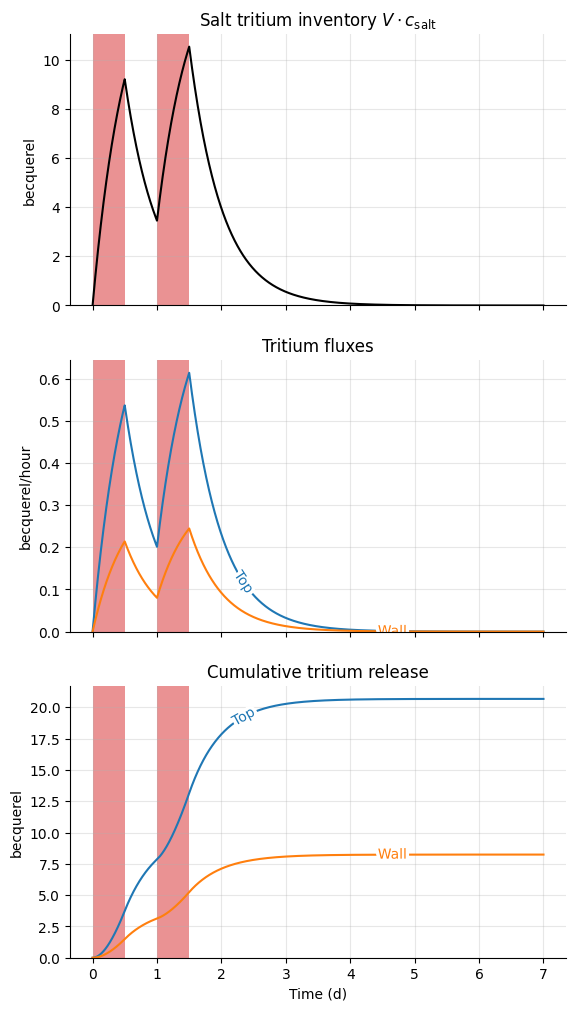

In [4]:
time = baby_model.times.to(ureg.day)

fig, (ax_inv, ax_fluxes, ax_cumul) = plt.subplots(3, 1, sharex=True, figsize=(6.4, 12))
plt.sca(ax_inv)
plt.title("Salt tritium inventory $V \cdot c_\mathrm{salt}$")
plt.plot(
    time,
    quantity_to_activity(baby_model.concentrations * baby_model.volume).to(ureg.Bq),
    color="black",
)

plt.sca(ax_fluxes)
plt.title("Tritium fluxes")
release_top = quantity_to_activity(baby_model.Q_top(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_top = release_top.to(ureg.Bq * ureg.h**-1)
release_walls = quantity_to_activity(baby_model.Q_wall(baby_model.concentrations)).to(
    ureg.Bq * ureg.s**-1
)
release_walls = release_walls.to(ureg.Bq * ureg.h**-1)
plt.plot(time, release_top, label="Top")
plt.plot(time, release_walls, label="Wall")

plt.sca(ax_cumul)
plt.title("Cumulative tritium release")
integrated_top = quantity_to_activity(baby_model.integrated_release_top()).to(ureg.Bq)
integrated_wall = quantity_to_activity(baby_model.integrated_release_wall()).to(ureg.Bq)

plt.plot(time, integrated_top, label="Top")
plt.plot(time, integrated_wall, label="Wall")
plt.xlabel(f"Time ({time.units:~P})")

for ax in [ax_inv, ax_fluxes, ax_cumul]:
    ax.set_ylim(bottom=0)
    ax.spines[["right", "top"]].set_visible(False)
    ax.grid(alpha=0.3)
    labelLines(ax.get_lines(), zorder=2.5)
    plt.sca(ax)
    plot_irradiation(baby_model, facecolor="tab:red", alpha=0.5)

plt.savefig("baby_run_4/basic_model_results.svg")
plt.show()


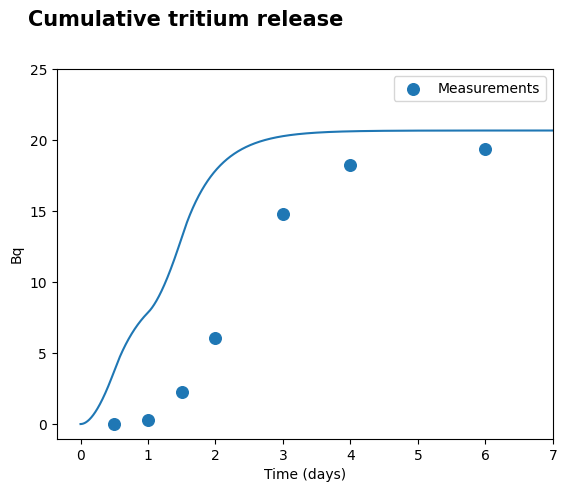

In [5]:
plt.figure()

# set x axis units to days
plt.gca().xaxis.set_units(ureg.day)
plot_integrated_top_release(baby_model)
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.gcf().text(0.08, 0.97, "Cumulative tritium release", weight="bold", fontsize=15)
plt.gca().set_axisbelow(True)
plt.ylim(top=25 * ureg.Bq)
plt.xlim(right=7 * ureg.day)
plt.xlabel("Time (days)")
plt.ylabel("Bq")
plt.savefig('baby_run_4/cumulative_tritium_release_experimental_only.svg')

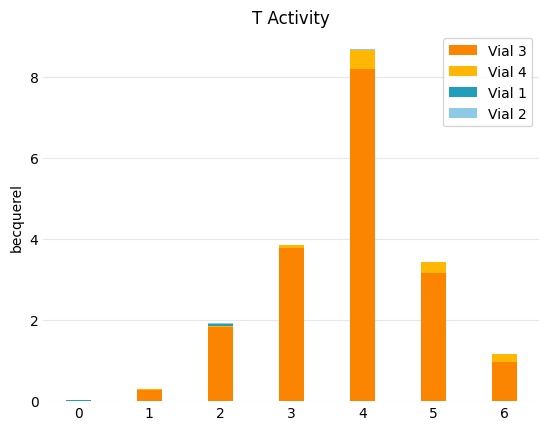

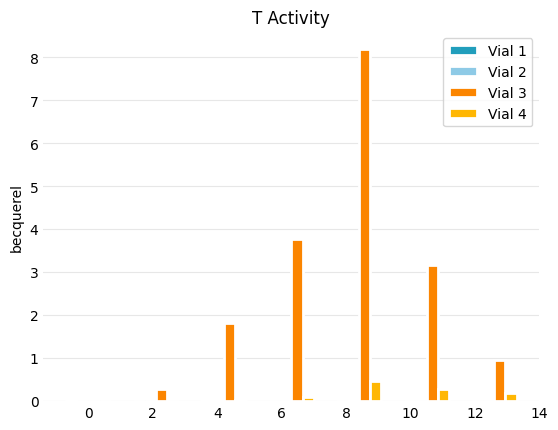

In [6]:
# Create the stacked bar plot
plt.figure()

for stacked in [True, False]:
    index = plot_bars(measurements_after_background_sub, stacked=stacked)
    # plt.xticks(index, ["Day 1", "Day 2", "Day 4"])
    plt.title("T Activity")
    plt.legend()
    plt.gca().spines[["right", "bottom", "top", "left"]].set_visible(False)
    plt.grid(True, axis="y", alpha=0.3)
    plt.gca().tick_params(axis="both", which="both", length=0)
    if stacked:
        plt.savefig("baby_run_4/LSC results_stacked.svg")
    else:
        plt.savefig("baby_run_4/LSC results.svg")
    plt.gca().set_axisbelow(True)
    plt.show()

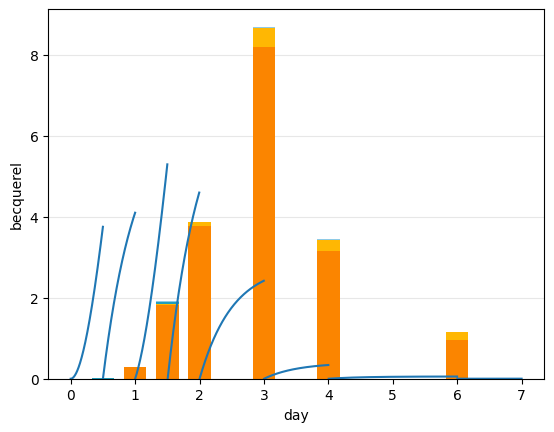

In [7]:
plt.figure()
plot_bars(measurements_after_background_sub, index=[time.to(ureg.day) for time in replacement_times])
plot_sample_activity_top(baby_model, replacement_times)

plt.grid(False)
plt.grid(True, axis="y", alpha=0.3)
plt.gca().set_axisbelow(True)
plt.savefig("baby_run_4/sample_activity.svg")


/home/remidm/miniconda3/envs/libra-calculations/lib/python3.13/site-packages/scipy/integrate/_ivp/base.py:23: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(fun(t, y), dtype=dtype)


(-1.0345396948768852, 25.0)

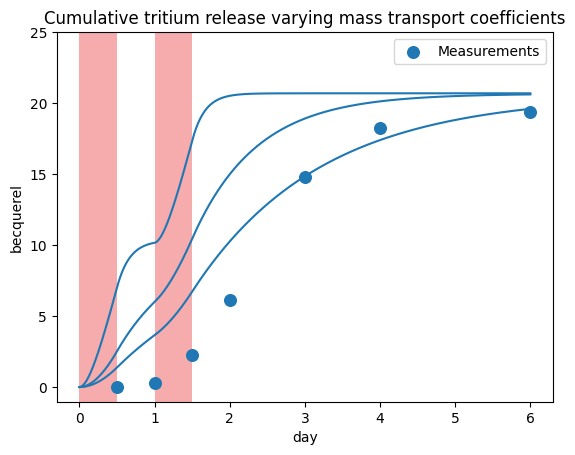

In [9]:
for i, mass_transport_coeff_factor2 in enumerate([0.1, 0.2, 1]):
    new_baby_model = Model(
        radius=baby_radius,
        height=baby_height,
        TBR=baby_model.TBR,
        k_top=baby_model.k_top * mass_transport_coeff_factor * mass_transport_coeff_factor2,
        k_wall=baby_model.k_wall * mass_transport_coeff_factor * mass_transport_coeff_factor2,
        neutron_rate=baby_model.neutron_rate,
        irradiations=baby_model.irradiations,
    )

    new_baby_model.run(6 * ureg.day)
    if i == 0:
        plot_irradiation(new_baby_model, facecolor="#EF5B5B", alpha=0.5)
    plot_integrated_top_release(new_baby_model, color="tab:blue")

plt.title("Cumulative tritium release varying mass transport coefficients")
s = plt.scatter(
    replacement_times,
    cumulative_release,
    s=70,
    label="Measurements",
)
plt.legend(handles=[s])
plt.ylim(top=25 * ureg.Bq)